# Chrun New Approach

In [1]:
# imports section
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv("../resources/churn.csv") 
print(f'num of rows: {len(df)}')

print(df.iloc[1]) # display second row

header_dict = {col: idx for idx, col in enumerate(df.columns)} 
print(header_dict) # 'index': 0

inverted_header_dict = {value: key for key, value in header_dict.items()}
print(inverted_header_dict) # 0: 'index'

num of rows: 1000
Customer_ID                           2
Age                                  65
Gender                             Male
Annual_Income                     79.51
Total_Spend                     9025.47
Years_as_Customer                    13
Num_of_Purchases                     77
Average_Transaction_Amount         22.9
Num_of_Returns                        2
Num_of_Support_Contacts               2
Satisfaction_Score                    3
Last_Purchase_Days_Ago              227
Email_Opt_In                      False
Promotion_Response            Responded
Target_Churn                      False
Name: 1, dtype: object
{'Customer_ID': 0, 'Age': 1, 'Gender': 2, 'Annual_Income': 3, 'Total_Spend': 4, 'Years_as_Customer': 5, 'Num_of_Purchases': 6, 'Average_Transaction_Amount': 7, 'Num_of_Returns': 8, 'Num_of_Support_Contacts': 9, 'Satisfaction_Score': 10, 'Last_Purchase_Days_Ago': 11, 'Email_Opt_In': 12, 'Promotion_Response': 13, 'Target_Churn': 14}
{0: 'Customer_ID', 1: 'Age

c:\Users\vmelnyk2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


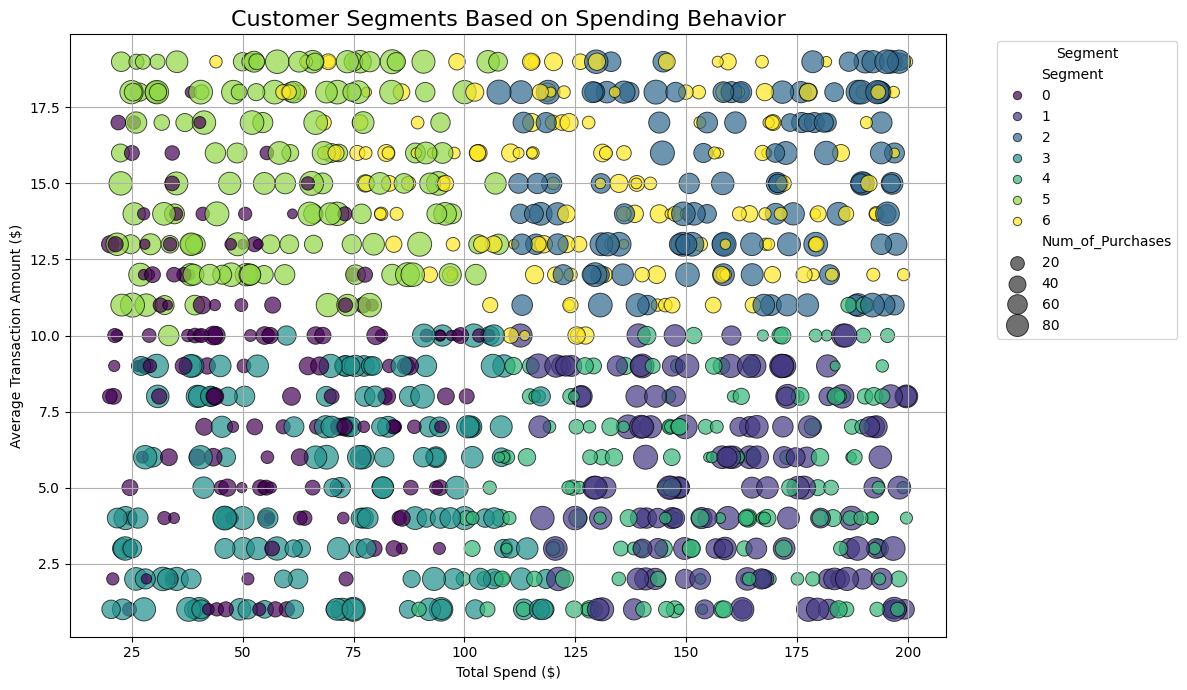

c:\Users\vmelnyk2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


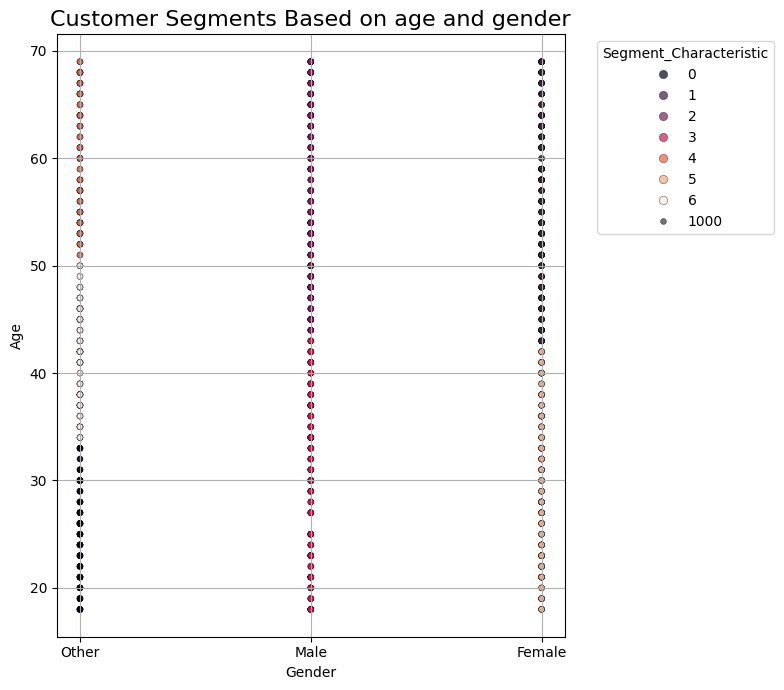

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df['Target_Churn_Int'] = df['Target_Churn'].astype(int)
df['Gender_Code'] = pd.Categorical(df['Gender']).codes

behavioral_features = ['Total_Spend', 'Average_Transaction_Amount', 'Num_of_Purchases']
clusterization_features = ['Annual_Income', 'Years_as_Customer', 'Num_of_Purchases']
characteristic_features = ['Gender_Code', 'Age']


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[clusterization_features])

kmeans = KMeans(n_clusters=7, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled_features)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x='Annual_Income',
    y='Years_as_Customer',
    size='Num_of_Purchases',
    sizes=(50, 300),
    hue='Segment',
    palette='viridis',
    alpha=0.7,
    edgecolor='black'
)

# Enhancing the plot aesthetics
plt.title('Customer Segments Based on Spending Behavior', fontsize=16)
plt.xlabel('Total Spend ($)')
plt.ylabel('Average Transaction Amount ($)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Cluster Age + Gender
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[characteristic_features])

kmeans = KMeans(n_clusters=7, random_state=42)
df['Segment_Characteristic'] = kmeans.fit_predict(scaled_features)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 7))
sns.scatterplot(
    data=df,
    x='Gender',
    y='Age',
    size=1000,
    hue='Segment_Characteristic',
    palette='rocket',
    alpha=0.7,
    edgecolor='black'
)

# Enhancing the plot aesthetics
plt.title('Customer Segments Based on age and gender', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Segment_Characteristic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Parameters based on typical Prospect Theory values (can be calibrated later)
alpha = 0.5      # sensitivity parameter for gains
beta = 0.5       # sensitivity parameter for losses
lambda_ = 1.6    # loss aversion coefficient (typical range: 2.0 - 2.5)
gamma = 0.61      # parameter for probability weighting function


# Calculate normalized satisfaction score (reference point)
# df['Normalized_Satisfaction'] = df['Satisfaction_Score'] / df['Satisfaction_Score'].max()
df['Normalized_Satisfaction'] = (( df['Satisfaction_Score'] / df['Satisfaction_Score'].max() 
                                 + df['Total_Spend'] / df['Total_Spend'].max() ) / 2 ).clip(lower=0)

# Estimate probability of churn from data
# churn_prob = df['Target_Churn'].mean()
# stay_prob = 1 - churn_prob

churn_total = df['Target_Churn'].mean()
stay_total = 1 - churn_total
print(f'Churn total: {churn_total}, Stay total: {stay_total}')

# Churn for each Segment
segmentation = 'Segment_Characteristic'
mean_churn_dict = df.groupby(segmentation)['Target_Churn'].mean().to_dict()

def calculate_w_P_stay(segment):
    churn_value = mean_churn_dict.get(segment, 0)  # Get the segment churn value
    stay_prob = 1 - churn_value
    return stay_prob  # Example calculation: probability of staying

def calculate_w_P_churn(segment):
    churn_value = mean_churn_dict.get(segment, 0)  # Get the segment churn value
    return churn_value  # Example calculation: probability of staying


# Apply probability weighting
df['w_P_stay'] = df[segmentation].map(calculate_w_P_stay)
df['w_P_churn'] = df[segmentation].map(calculate_w_P_churn)



# Compute value functions for Gain and Loss based on Satisfaction_Score
df['V_Gain'] = (df['Normalized_Satisfaction'] ** alpha)
df['V_Loss'] = lambda_ * ((1 - df['Normalized_Satisfaction']) ** beta)


# Calculate Customer Utility based on CPT formula
df['Customer_Utility'] = (df['w_P_stay'] * df['V_Gain']) - (df['w_P_churn'] * df['V_Loss'])

# Display the results clearly (first 10 customers)
display_columns = [ 'Customer_ID', 'Satisfaction_Score', 'Normalized_Satisfaction',
                   'Gender', 'Age',
                   'Annual_Income', 'V_Gain', 'V_Loss', 'w_P_stay', 'w_P_churn',
                   segmentation, 'Customer_Utility', 'Target_Churn']

# Displaying the calculated utilities
print("Customer Utility Function based on CPT (first 20 rows):")
display(df[display_columns].head(20))



from sklearn.metrics import confusion_matrix

df['Customer_Utility_binary'] = df['Customer_Utility'] > 0  
df['Customer_Utility_binary'] = df['Customer_Utility_binary'].astype(int)  # Convert to 0/1
# df['b_numeric'] = df['b'].astype(int)

cm = confusion_matrix(df['Target_Churn_Int'], df['Customer_Utility_binary'])
print("Confusion Matrix:\n", cm)

filtered_df = pd.DataFrame(df[((df['Customer_Utility'] < 0) & (df['Target_Churn_Int'] == 0)) 
                | ((df['Customer_Utility'] > 0) & (df['Target_Churn_Int'] == 1))].copy())
display(filtered_df[display_columns].head(20))

Churn total: 0.526, Stay total: 0.474
Customer Utility Function based on CPT (first 20 rows):


Customer_ID  Satisfaction_Score  Normalized_Satisfaction  Gender  Age  \
0             1                   3                 0.594640   Other   62   
1             2                   3                 0.751290    Male   65   
2             3                   2                 0.230943    Male   18   
3             4                   5                 0.955531   Other   21   
4             5                   5                 0.769554   Other   21   
5             6                   4                 0.412760    Male   57   
6             7                   1                 0.275634    Male   27   
7             8                   3                 0.663558   Other   37   
8             9                   4                 0.646783   Other   39   
9            10                   2                 0.690196   Other   68   
10           11                   2                 0.414200    Male   54   
11           12                   2                 0.366691  Female   41   
12           13                   5                 0.911742   Other   24   
13           14                   2                 0.476224  Female   42   
14           15                   1                 0.442764  Female   42   
15           16                   3                 0.703837    Male   30   
16           17                   2                 0.537369    Male   19   
17           18                   3                 0.514099  Female   56   
18           19                   4                 0.466776    Male   57   
19           20                   5                 0.792234   Other   41   

    Annual_Income    V_Gain    V_Loss  w_P_stay  w_P_churn  \
0           45.15  0.771129  1.018687  0.450000   0.550000   
1           79.51  0.866770  0.797934  0.478022   0.521978   
2           29.19  0.480565  1.403135  0.513158   0.486842   
3           79.63  0.977513  0.337401  0.452174   0.547826   
4           77.66  0.877242  0.768077  0.452174   0.547826   
5          190.43  0.642464  1.226105  0.478022   0.521978   
6          172.13  0.525008  1.361755  0.513158   0.486842   
7           88.90  0.814591  0.928058  0.449541   0.550459   
8           24.46  0.804228  0.950912  0.449541   0.550459   
9          169.59  0.830780  0.890560  0.450000   0.550000   
10         138.90  0.643583  1.224601  0.478022   0.521978   
11          47.43  0.605550  1.273292  0.455696   0.544304   
12         199.29  0.954852  0.475331  0.452174   0.547826   
13          38.04  0.690090  1.157958  0.455696   0.544304   
14         176.08  0.665405  1.194372  0.455696   0.544304   
15          72.97  0.838950  0.870734  0.513158   0.486842   
16          98.36  0.733054  1.088272  0.513158   0.486842   
17         163.18  0.717007  1.115305  0.494565   0.505435   
18         141.95  0.683210  1.168355  0.478022   0.521978   
19         188.82  0.890075  0.729303  0.449541   0.550459   

    Segment_Characteristic  Customer_Utility  Target_Churn  
0                        4         -0.213270          True  
1                        2         -0.002169         False  
2                        3         -0.436499          True  
3                        0          0.257169          True  
4                        0         -0.024107         False  
5                        2         -0.332888         False  
6                        3         -0.393548         False  
7                        6         -0.144665         False  
8                        6         -0.161904          True  
9                        4         -0.115957         False  
10                       2         -0.331568         False  
11                       5         -0.417111          True  
12                       0          0.171360         False  
13                       5         -0.315810          True  
14                       5         -0.346879          True  
15                       3          0.006604         False  
16                       3         -0.153644  

Confusion Matrix:
 [[389  85]
 [442  84]]


Customer_ID  Satisfaction_Score  Normalized_Satisfaction  Gender  Age  \
1             2                   3                 0.751290    Male   65   
3             4                   5                 0.955531   Other   21   
4             5                   5                 0.769554   Other   21   
5             6                   4                 0.412760    Male   57   
6             7                   1                 0.275634    Male   27   
7             8                   3                 0.663558   Other   37   
9            10                   2                 0.690196   Other   68   
10           11                   2                 0.414200    Male   54   
17           18                   3                 0.514099  Female   56   
18           19                   4                 0.466776    Male   57   
21           22                   1                 0.312360  Female   42   
25           26                   1                 0.517345  Female   31   
27           28                   1                 0.150032    Male   27   
28           29                   5                 0.990603    Male   38   
29           30                   1                 0.226700  Female   69   
30           31                   4                 0.756713    Male   34   
34           35                   5                 0.862478  Female   65   
37           38                   2                 0.623475  Female   53   
38           39                   5                 0.769592   Other   42   
39           40                   5                 0.715161    Male   67   

    Annual_Income    V_Gain    V_Loss  w_P_stay  w_P_churn  \
1           79.51  0.866770  0.797934  0.478022   0.521978   
3           79.63  0.977513  0.337401  0.452174   0.547826   
4           77.66  0.877242  0.768077  0.452174   0.547826   
5          190.43  0.642464  1.226105  0.478022   0.521978   
6          172.13  0.525008  1.361755  0.513158   0.486842   
7           88.90  0.814591  0.928058  0.449541   0.550459   
9          169.59  0.830780  0.890560  0.450000   0.550000   
10         138.90  0.643583  1.224601  0.478022   0.521978   
17         163.18  0.717007  1.115305  0.494565   0.505435   
18         141.95  0.683210  1.168355  0.478022   0.521978   
21          37.61  0.558891  1.326785  0.455696   0.544304   
25          29.67  0.719267  1.111575  0.455696   0.544304   
27          50.14  0.387339  1.475100  0.513158   0.486842   
28         167.94  0.995290  0.155104  0.513158   0.486842   
29         146.10  0.476130  1.407000  0.494565   0.505435   
30         178.95  0.869892  0.789186  0.513158   0.486842   
34         130.66  0.928697  0.593344  0.494565   0.505435   
37          81.58  0.789604  0.981786  0.494565   0.505435   
38         168.22  0.877264  0.768014  0.449541   0.550459   
39         175.90  0.845672  0.853925  0.478022   0.521978   

    Segment_Characteristic  Customer_Utility  Target_Churn  
1                        2         -0.002169         False  
3                        0          0.257169          True  
4                        0         -0.024107         False  
5                        2         -0.332888         False  
6                        3         -0.393548         False  
7                        6         -0.144665         False  
9                        4         -0.115957         False  
10                       2         -0.331568         False  
17                       1         -0.209107         False  
18                       2         -0.283266         False  
21                       5         -0.467490         False  
25                       5         -0.277267         False  
27                       3         -0.519374         False  
28                       3          0.435230          True  
29                       1         -0.475669         False  
30                       3          0.062183          True  
34                       1          0.159404  

In [10]:
def utility_to_optimize(a, b, l):
    # df['Normalized_Satisfaction'] = df['Satisfaction_Score'] / df['Satisfaction_Score'].max()
    df['Normalized_Satisfaction'] = (( df['Satisfaction_Score'] / df['Satisfaction_Score'].max() 
                                 + df['Total_Spend'] / df['Total_Spend'].max() ) / 2 ).clip(lower=0)
    
    churn_total = df['Target_Churn'].mean()
    stay_total = 1 - churn_total

    segmentation = 'Segment'
    mean_churn_dict = df.groupby(segmentation)['Target_Churn'].mean().to_dict()

    def calculate_w_P_stay(segment):
        churn_value = mean_churn_dict.get(segment, 0)  # Get the segment churn value
        stay_prob = 1 - churn_value
        return stay_prob  # Example calculation: probability of staying

    def calculate_w_P_churn(segment):
        churn_value = mean_churn_dict.get(segment, 0)  # Get the segment churn value
        return churn_value  # Example calculation: probability of staying
    
    df['w_P_stay'] = df[segmentation].map(calculate_w_P_stay)
    df['w_P_churn'] = df[segmentation].map(calculate_w_P_churn)

    df['V_Gain'] = (df['Normalized_Satisfaction'] ** a)
    df['V_Loss'] = l * ((1 - df['Normalized_Satisfaction']) ** b)

    df['Customer_Utility'] = (df['w_P_stay'] * df['V_Gain']) - (df['w_P_churn'] * df['V_Loss'])
    df['Customer_Utility_binary'] = df['Customer_Utility'] > 0  
    cm = confusion_matrix(df['Target_Churn_Int'], df['Customer_Utility_binary'])
    # print(cm)
    return (cm[0][1] + cm[1][0])/ (cm.sum())

print(utility_to_optimize(0.8, 0.8, 2.1))

from bayes_opt import BayesianOptimization

def black_box_function(param1, param2, param3):
    return utility_to_optimize(param1, param2, param3)  # Replace with your function

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds={'param1': (0.0, 0.9), 'param2': (0.0, 0.9), 'param3': (1.9, 2.5)},
    random_state=42,
)

optimizer.maximize(n_iter=200)
print(optimizer.max)


0.521
|   iter    |  target   |  param1   |  param2   |  param3   |
-------------------------------------------------------------
| 1         | 0.519     | 0.3371    | 0.8556    | 2.339     |
| 2         | 0.527     | 0.5388    | 0.1404    | 1.994     |
| 3         | 0.516     | 0.05228   | 0.7796    | 2.261     |
| 4         | 0.526     | 0.6373    | 0.01853   | 2.482     |
| 5         | 0.53      | 0.7492    | 0.1911    | 2.009     |
| 6         | 0.524     | 0.9       | 0.6662    | 1.9       |
| 7         | 0.53      | 0.748     | 0.1741    | 2.036     |
| 8         | 0.526     | 0.879     | 0.01003   | 1.91      |
| 9         | 0.527     | 0.8887    | 0.3477    | 2.384     |
| 10        | 0.526     | 0.01746   | 0.006359  | 2.482     |
| 11        | 0.526     | 0.007512  | 0.015     | 1.947     |
| 12        | 0.526     | 0.8996    | 0.3137    | 2.064     |
| 13        | 0.525     | 0.8917    | 0.8867    | 2.497     |
| 14        | 0.527     | 0.61      | 0.3243    | 2.236     |
| 

Customer_ID  Age  Gender  Annual_Income  Total_Spend  Years_as_Customer  \
0             1   62       2          45.15      5892.58                  5   
1             2   65       1          79.51      9025.47                 13   
2             3   18       1          29.19       618.83                 13   
3             4   21       2          79.63      9110.30                  3   
4             5   21       2          77.66      5390.88                 15   
5             6   57       1         190.43       255.19                 19   
6             7   27       1         172.13      3512.55                  3   
7             8   37       2          88.90      7270.90                  4   
8             9   39       2          24.46      4935.49                  1   
9            10   68       2         169.59      9803.57                 17   
10           11   54       1         138.90      4283.84                 15   
11           12   41       0          47.43      3333.69                  4   
12           13   24       2         199.29      8234.55                  1   
13           14   42       0          38.04      5524.28                 12   
14           15   42       0         176.08      6855.03                 17   
15           16   30       1          72.97      8076.45                  9   
16           17   19       1          98.36      6747.13                 10   
17           18   56       0         163.18      4281.83                  3   
18           19   57       1         141.95      1335.48                 15   
19           20   41       2         188.82      5844.46                 11   

    Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
0                 22                      453.80               2   
1                 77                       22.90               2   
2                 71                       50.53               5   
3                 33                      411.83               5   
4                 43                      101.19               3   
5                 85                      417.78               5   
6                 77                      316.18               0   
7                 87                       63.61               3   
8                 21                      173.80               9   
9                 34                      481.18               6   
10                33                       96.55               9   
11                10                      212.58               0   
12                60                      160.58               2   
13                 4                      259.81               5   
14                64                      222.85               6   
15                63                      466.61               5   
16                 9                      414.80               7   
17                29                      294.39               7   
18                14                      173.58               7   
19                88                      378.05               8   

    Num_of_Support_Contacts  Satisfaction_Score  Last_Purchase_Days_Ago  \
0                         0                   3                     129   
1                         2                   3                     227   
2                         2                   2                     283   
3                         3                   5                     226   
4                         0                   5                     242   
5                         1                   4                     130   
6                         3                   1                      61   
7                         4                   3                     224   
8                         2                   4                     126   
9                         1                   2                     171   
10                        1                   2                      92   
11             

Accuracy: 0.5600
              precision    recall  f1-score   support

       False       0.54      0.40      0.46        94
        True       0.57      0.70      0.63       106

    accuracy                           0.56       200
   macro avg       0.56      0.55      0.55       200
weighted avg       0.56      0.56      0.55       200



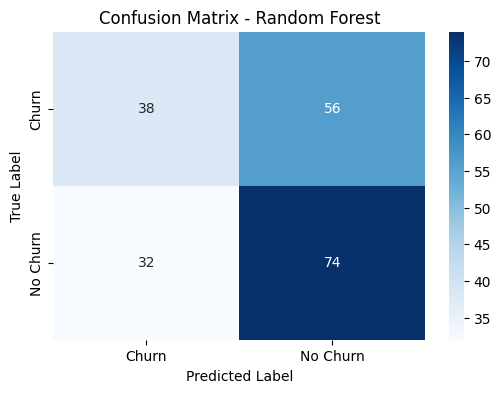

                       Feature  Importance
10      Last_Purchase_Days_Ago    0.122647
2                Annual_Income    0.118277
3                  Total_Spend    0.114519
6   Average_Transaction_Amount    0.114116
5             Num_of_Purchases    0.106628
0                          Age    0.102322
4            Years_as_Customer    0.078307
7               Num_of_Returns    0.066257
8      Num_of_Support_Contacts    0.049075
9           Satisfaction_Score    0.048130


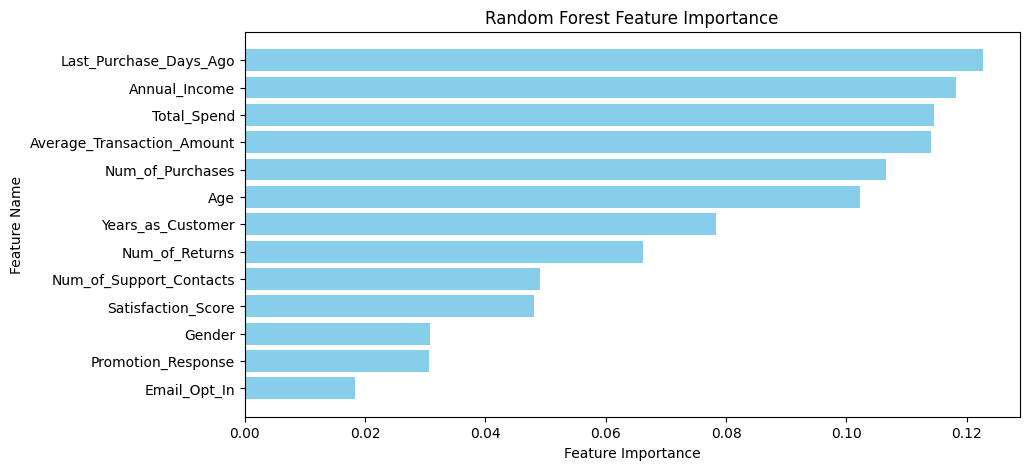

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# prepare the data
# Promotion_Response

df = pd.read_csv("../resources/churn.csv") 
df_copy = df.copy()
df_copy["Gender"] = df_copy["Gender"].astype("category").cat.codes
df_copy["Promotion_Response"] = df_copy["Promotion_Response"].astype("category").cat.codes

display(df_copy.head(20))


X = df_copy.drop(columns=["Target_Churn", "Customer_ID", "Target_Churn_Int"], errors="ignore")
y = df_copy["Target_Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train rf classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# confusion matrix:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Churn", "No Churn"], yticklabels=["Churn", "No Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# feature importance analysis:

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({ # dataframe for visualization
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(10)) # top 10 features

plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.show()


**SVM**

Accuracy: 0.5450
              precision    recall  f1-score   support

       False       0.53      0.38      0.44        95
        True       0.55      0.70      0.62       105

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.55      0.53       200



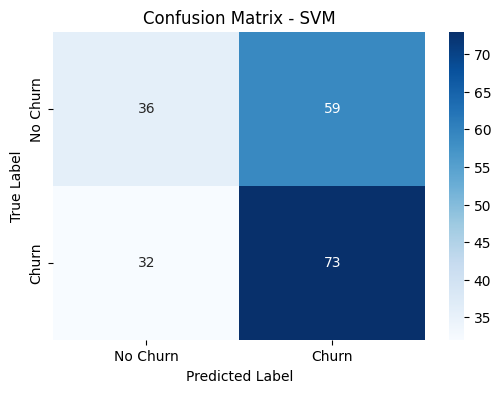

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv('processed_customer_churn_data.csv')

feature_columns = [
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]
target_column = 'Target_Churn'

X = data[feature_columns]
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now explicitly scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_probs = svm_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()


In [7]:
thresholds = np.arange(0.1, 0.9, 0.1)

for threshold in thresholds:
    y_pred_thresh = (y_probs >= threshold).astype(int)
    unique, counts = np.unique(y_pred_thresh, return_counts=True)
    print(f"Threshold {threshold:.1f}: Predicted classes {dict(zip(unique, counts))}")

Threshold 0.1: Predicted classes {1: 200}
Threshold 0.2: Predicted classes {1: 200}
Threshold 0.3: Predicted classes {1: 200}
Threshold 0.4: Predicted classes {1: 200}
Threshold 0.5: Predicted classes {0: 68, 1: 132}
Threshold 0.6: Predicted classes {0: 200}
Threshold 0.7: Predicted classes {0: 200}
Threshold 0.8: Predicted classes {0: 200}
